## Famous Iris data set (flower data)

pro: small data set, but 4D, and maybe impossible to cluster into the three groups of flowers according to wikipedia.  can be compared to the clustering into setosa, versicolor, virginica (three types of the flower). one could hope that if one looks for three clusters, one will get the three meaningful ones.

con: see e.g. https://en.wikipedia.org/wiki/Iris_flower_data_set:
"Based on Fisher's linear discriminant model, this data set became a typical test case for many statistical classification techniques in machine learning such as support vector machines.
The use of this data set in cluster analysis however is not common, since the data set only contains two clusters with rather obvious separation. One of the clusters contains Iris setosa, while the other cluster contains both Iris virginica and Iris versicolor and is not separable without the species information Fisher used. This makes the data set a good example to explain the difference between supervised and unsupervised techniques in data mining: Fisher's linear discriminant model can only be obtained when the object species are known: class labels and clusters are not necessarily the same."

Remark: For certain parameters and some algorithms (especially density based), the clustering will result in three clusters similar to the ones given by expert knowledge. BUT using consensus clustering, the consensus seems to be two clusters! Because the data set is quite small, it's possible to find parameters (using parameter search), such that the NMI between the consensus and the result given the NMI-optimal parameters is 1 :)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from consensus_clustering.load_data import load_iris, load_iris_labeled
from consensus_clustering import consensus
from consensus_clustering.lib import distance as cl_dist
from consensus_clustering.lib import density
from consensus_clustering.lib import similarity
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn.apionly as sns
import sys
#sns.set(style="ticks", color_codes=True)
%matplotlib inline

### Data

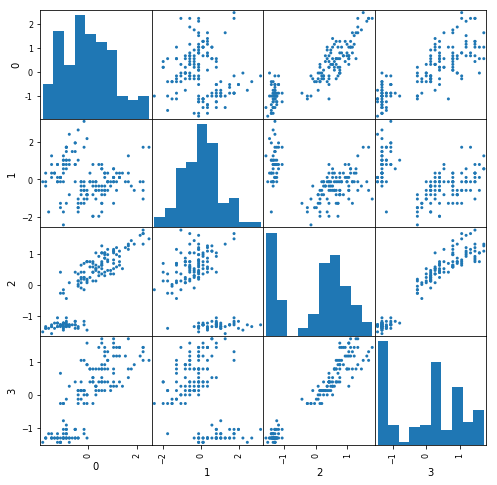

In [3]:
#load data (unlabeled)
data=load_iris(scale = 'True') #preprocess data

#visualize as 4x4 plots, for each of the 4 dimensions
s=scatter_matrix(pd.DataFrame(data), alpha=1, figsize=(8,8), cmap='Set2')

### DBSCAN Example

In [50]:
dbscan_obj = density.DBSCAN(data,eps=0.8, minPts=7)
dbscan_obj.fit()
labels = dbscan_obj._cluster_labels

Detected 2 clusters
Finished after 0:00:00.010476
Rate of noise in dataset: 0.046667


DBSCAN clustering results (parameters for DBSCAN chosen by trying out different values)

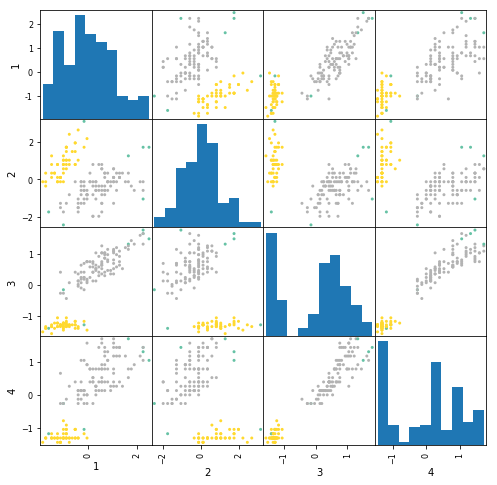

In [51]:
dataframeds=pd.DataFrame(data,columns=["1","2","3","4"])
dataframeds["labels"]=labels

#plot clustering result
s=scatter_matrix(dataframeds[["1","2","3","4"]], alpha=1, figsize=(8,8), c = labels, cmap='Set2')

### Mean Shift Algorithm, another density-based method

92 iterations until termination.
Used bandwidth: 0.370000
Finished after 0.48743508261128454
Number of clusters found: 4.000000
There is/are 1.000000 outliers
Max within cluster distance to center: 0.014051
Mean within cluster distance to center: 0.006304
Sum of within cluster squared errors: 0.008267


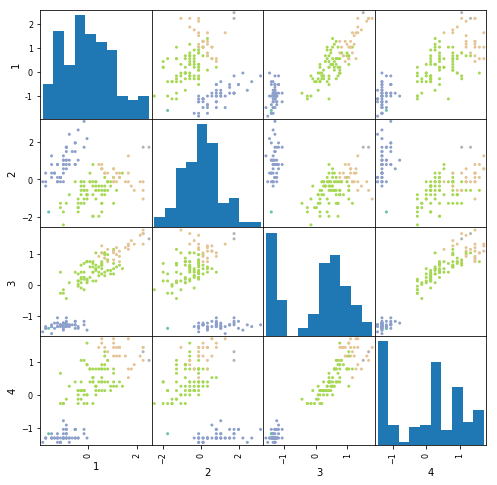

In [52]:
#mean shift algorithm
ms_obj = density.MeanShift(data, bandwidth=0.37, mindist=0.03)
ms_obj.fit()
labels = ms_obj.cluster_labels

#visualization as 4x4 plots for each of the 4 dimensions
dataframems=pd.DataFrame(data,columns=["1","2","3","4"])
dataframems["labels"]=labels
s=scatter_matrix(dataframems[["1","2","3","4"]], alpha=1, figsize=(8,8), c = labels, cmap='Set2')

### K-Means with three clusters

terminated by break condition
6 iterations until termination.
Finished after 0:00:00.005113
max within-cluster distance to center: 2.979570
mean within-cluster distance to center: 0.993504
sum of within cluster squared errors: 192.037176


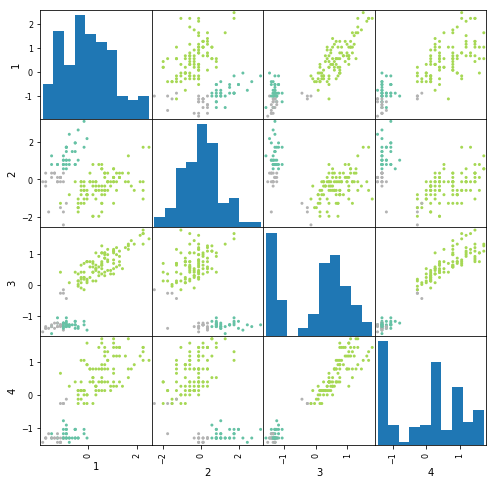

In [53]:
k = 3

# Fit
kmeans_obj = cl_dist.KMeans(data, k)
kmeans_obj.fit()
labels = kmeans_obj.cluster_labels

# Plot
dataframekm=pd.DataFrame(data,columns=["1","2","3","4"])
dataframekm["labels"]=labels
s=scatter_matrix(dataframekm[["1","2","3","4"]], alpha=1, figsize=(8,8), c = labels, cmap='Set2')

### Spectral Clustering with three clusters

Constructing gaussian similarity matrix
Computing generalized Laplacian eigenproblem


KMeans initialization on eigenvectors...
terminated by break condition
10 iterations until termination.
Finished after 0:00:00.006041
max within-cluster distance to center: 1.476071
mean within-cluster distance to center: 0.303689
sum of within cluster squared errors: 22.597562
KMeans terminated. 

Finished after 0:00:00.032560


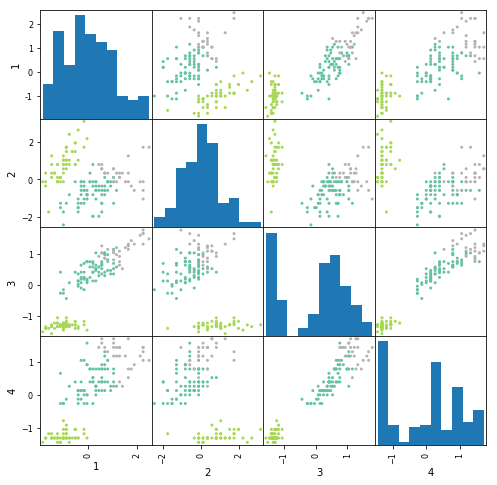

In [55]:
k = 3
bandwidth = 3

# Fit
spectral_obj = similarity.SpectralClustering(data, k=k, bandwidth=bandwidth)
spectral_obj.fit()
labels = spectral_obj.cluster_labels

# Plot
dataframesp=pd.DataFrame(data,columns=["1","2","3","4"])
dataframesp["labels"]=labels
s=scatter_matrix(dataframesp[["1","2","3","4"]], alpha=1, figsize=(8,8), c = labels, cmap='Set2')


### Consensus clustering

Now we are ready to try out Consensus clustering on the just found clustering results (of KMeans, DBScan, Spectral Clustering and Mean Shift), setting the number of clusters to four. when setting to three, there is one point (outlier somehow) that is put into one cluster on its own.

Hierarchical clustering terminated.
Finished after 0:00:00.022323
Stopping cluster number was reached.
Current number of clusters: 4
Current minimum cluster distance: 0.55
mutual information: 146.52531993071065
entropy a: -158.7049649210682
entropy b: -155.6922935034899
mutual information: 87.37535305903602
entropy a: -158.7049649210682
entropy b: -134.51138487005187
mutual information: 92.41416789914581
entropy a: -158.7049649210682
entropy b: -98.08489383013443
mutual information: 158.7049649210682
entropy a: -158.7049649210682
entropy b: -165.8343703203602
Consensus clustering terminated.
Finished after 0:00:00.081675
ANMI (average normalized mutual information) of consensus with clusterings: 0.812


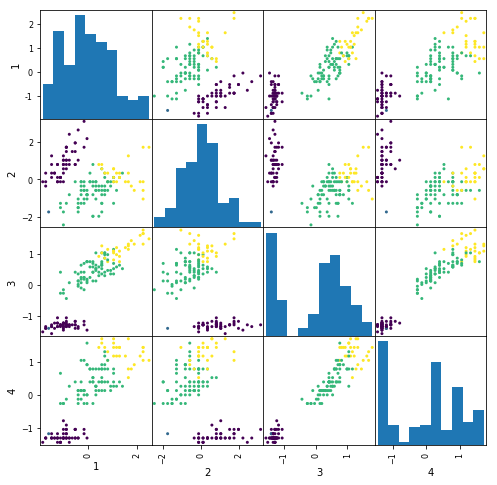

In [58]:
n = len(data)
clusterings = [spectral_obj, kmeans_obj, dbscan_obj, ms_obj]
recluster_what = 'points'
how = 'hierarchical'
k = 4

# Fit
consensus_obj = consensus.Consensus(clusterings=clusterings, k=k, recluster_what=recluster_what, how=how)
consensus_obj.fit()
labels = consensus_obj.cluster_labels

# Plot
dataframecs=pd.DataFrame(data,columns=["1","2","3","4"])
dataframecs["labels"]=labels
s=scatter_matrix(dataframecs[["1","2","3","4"]], alpha=1, figsize=(8,8), c = labels)#, cmap='Set2')

check with "true" meaningful labels of the partition into three types of flowers

In [59]:
iris = sns.load_dataset("iris")

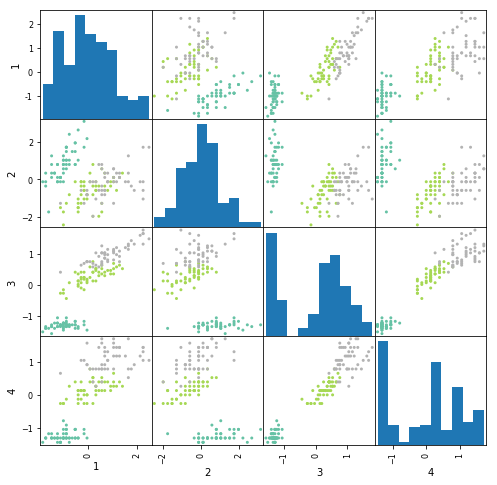

In [61]:
#true labels by grouping the plants (biology expert knowledge)
foundlabels=np.zeros((150,))
for j in range(150):
    if iris["species"][j]=='setosa':
        foundlabels[j]=0
    if iris["species"][j]=='versicolor':
        foundlabels[j]=1
    if iris["species"][j]=='virginica':
        foundlabels[j]=2
    
dataframelb=pd.DataFrame(data,columns=["1","2","3","4"])
dataframelb["labels"]=foundlabels
s=scatter_matrix(dataframelb[["1","2","3","4"]], alpha=1, figsize=(8,8), c = dataframelb["labels"], cmap='Set2')

Calculating the Fowlkes-Mallows index to check how well the consensus clustering agrees with the expert/true cluster

In [62]:
# Calculating the Fowlkes-Mallows index which lies in [0 1], the closer to 1 the better
from sklearn import metrics
fm_index = metrics.fowlkes_mallows_score(foundlabels, labels) 
fm_index

0.76900699560756169

And the mutual information between the "true" clustering and the consensus clustering

In [63]:
mutinf = metrics.adjusted_mutual_info_score(foundlabels, labels)  
mutinf

0.71859835914080583

### Parameter search for DBSCAN

In [64]:
def param_search_dbscan(data, k_consensus, recluster_what, recluster_how, eps_arr, min_pts_arr):
    num_objects = len(eps_arr)
    dbscan_objects = [None] * num_objects
    dbscan_obj = None

    print("Fit DBSCAN objects")

    # Fit DBSCAN objects
    for i, (eps, minPts) in enumerate(zip(eps_arr, min_pts_arr)):
        sys.stdout.write('\reps: {0}, minPts: {1}'.format(eps, minPts))
        dbscan_obj = density.DBSCAN(data, eps=eps, minPts=minPts, verbose=False)
        dbscan_obj.fit()
        dbscan_objects[i] = dbscan_obj

    print("\nFit consensus")

    # Fit consensus
    clusterings = [*dbscan_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(dbscan_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, dbscan_objects, consensus_obj

In [65]:
def plot_results(data, cl_objects, nmi_arr, consensus_obj, algorithm, arr_x, arr_y):
    # Put labels in right order in to the labels array
    no_labels = [0] * len(data)
    clusterings_labels = []
    for obj in cl_objects:
        clusterings_labels.append(consensus_obj._noise_to_zero(obj).cluster_labels)
    print("Number of clusterings:", len(clusterings_labels))

    # Init plotting arrangement
    num_plots = len(cl_objects) + 2
    num_subplts_per_row = 6
    num_rows = np.ceil(num_plots / num_subplts_per_row).astype(int) + 1
    num_x_param = len(arr_x)
    num_y_param = len(arr_y)
    if num_y_param > 1:
        num_subplts_per_row = num_x_param
        num_rows = num_y_param + 1
    num_cols = min(num_subplts_per_row, num_plots)
    fig, axarr = plt.subplots(num_rows,num_cols, figsize=(17, 3*num_rows))

    # Plot labels
    for i, ax in enumerate(axarr.flat):
        cur_x = i % num_subplts_per_row
        cur_y = i // num_subplts_per_row - 1 # do not count first row with original data and consensus
        ax.axis('off')
        if i==0:
            ax.set_title('Original data')
            ax.set_aspect('equal')
            ax.scatter(data[:, 0], data[:, 1], s=40, c=no_labels, cmap='Set2', alpha=0.2)
        elif i==1:
            ax.set_title('Consensus')
            ax.set_aspect('equal')
            ax.scatter(data[:, 0], data[:, 1], s=40, c=consensus_obj.cluster_labels, cmap='Set2', alpha=0.2)
        elif any((i < num_subplts_per_row, i-num_subplts_per_row >= len(clusterings_labels))):
            continue
        else:   
            ax.set_aspect('equal')
            ax.scatter(data[:, 0], data[:, 1], s=40, c=clusterings_labels[i-num_subplts_per_row], cmap='Set2', alpha=0.2)
            if algorithm == 'kmeans':
                ax.set_title('k = {:}, \nNMI = {:.3}'.format(k_arr[i-num_subplts_per_row], nmi_arr[i-num_subplts_per_row]))
            elif algorithm == 'dbscan':
#                 print(cur_x)
#                 print(cur_y)
                ax.set_title('eps = {:.3}, minPts = {:}\nNMI = {:.3}'.format(arr_x[cur_x], arr_y[cur_y], nmi_arr[i-num_subplts_per_row]))
            elif algorithm == 'meanshift':
                ax.set_title('bw = {:.3}, mindist = {:}\nNMI = {:.3}'.format(arr_x[cur_x], arr_y[cur_y], nmi_arr[i-num_subplts_per_row]))
           
            else:
                print("ERROR: Could not recognize algorithm parameter!")
                break

    plt.tight_layout()
    plt.show()
    #fig.savefig("bandwidth estimation.png")

In [67]:
# Set parameters:

# General
stride = 1
data = data
k_consensus = 3
recluster_what = 'points'
recluster_how = 'hierarchical'

# DBSCAN
n_eps = 8
n_min_pts =10
eps_arr = np.linspace(0.5, 1.2, n_eps)
min_pts_min = 5
min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts,3)
mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)

In [68]:
nmi_arr_db, cl_objects_db, consensus_obj_db = param_search_dbscan(
    data = data,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    eps_arr = mesh_eps.flatten(),
    min_pts_arr = mesh_min_pts.flatten())

Fit DBSCAN objects
eps: 1.2, minPts: 14999, minPts: 14
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:00.011946
Stopping cluster number was reached.
Current number of clusters: 3
Current minimum cluster distance: 0.57
mutual information: 82.21233008843468
entropy a: -122.72881431032617
entropy b: -107.54409552326251
mutual information: 88.27424648794994
entropy a: -122.72881431032617
entropy b: -105.71761945260744
mutual information: 92.71230137602977
entropy a: -122.72881431032617
entropy b: -98.62285370470917
mutual information: 94.33400469356472
entropy a: -122.72881431032617
entropy b: -97.10659341580451
mutual information: 94.33400469356472
entropy a: -122.72881431032617
entropy b: -97.10659341580451
mutual information: 94.18736256878415
entropy a: -122.72881431032617
entropy b: -96.53738071501283
mutual information: 94.23187132079005
entropy a: -122.72881431032617
entropy b: -95.95796375550074
mutual information: 94.4337258657406
entropy a: -122.72881431032

Number of clusterings: 32


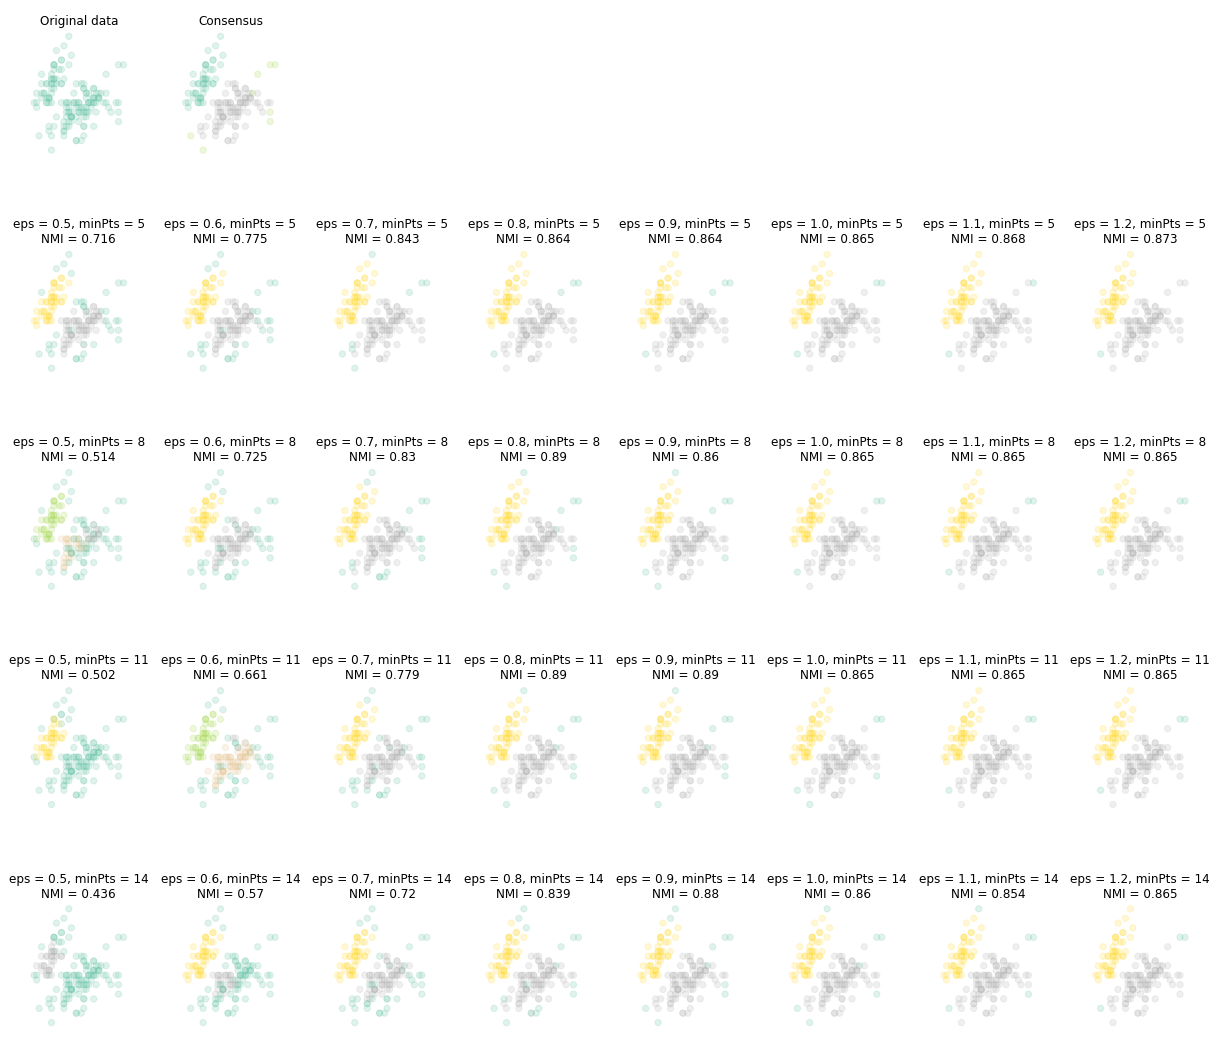

In [69]:
plot_results(data=data, cl_objects=cl_objects_db, nmi_arr=nmi_arr_db, consensus_obj=consensus_obj_db, algorithm='dbscan', arr_x=eps_arr, arr_y=min_pts_arr)

In [70]:
#compare with true labels from expert knowledge (and calculate mutual information and fowlkes mallows index)

iris = sns.load_dataset("iris")
foundlabels=np.zeros((150,))
for j in range(150):
    if iris["species"][j]=='setosa':
        foundlabels[j]=0
    if iris["species"][j]=='versicolor':
        foundlabels[j]=1
    if iris["species"][j]=='virginica':
        foundlabels[j]=2
        
mutinf_cons = metrics.adjusted_mutual_info_score(consensus_obj_db.cluster_labels, foundlabels)  
fm_index_cons = metrics.fowlkes_mallows_score(foundlabels, labels) 

In [71]:
print("Mutual information between consensus clustering labels and natural/true labels:", mutinf_cons)
print("Fowlkes-Mallows index between consensus clustering labels and natural/true labels:", fm_index_cons)

Mutual information between consensus clustering labels and natural/true labels: 0.559667322221
Fowlkes-Mallows index between consensus clustering labels and natural/true labels: 0.769006995608


In [72]:
#best parameters for DBSCAN -> highest NMI with consensus clustering (might not be unique parameter choice)
print("The best parameter choice for DBSCAN (given the chosen range) has NMI ", np.max(nmi_arr_db), " compared to the consensus result")

The best parameter choice for DBSCAN (given the chosen range) has NMI  0.889849427966  compared to the consensus result


### Parameter Search with Mean Shift

In [73]:
def param_search_meanshift(data, k_consensus, recluster_what, recluster_how, bandwidth_arr,mindist_arr):
    num_objects = len(bandwidth_arr)
    ms_objects = [None] * num_objects
    ms_obj = None

    print("Fit Mean Shift objects")

    #Fit Mean Shift objects
    for i, (bandwidth, mindist) in enumerate(zip(bandwidth_arr, mindist_arr)):
        sys.stdout.write('\rbandwidth: {0}, mindist: {1}'.format(bandwidth, mindist))
        ms_obj = density.MeanShift(data, bandwidth=bandwidth, mindist=mindist, verbose=False)
        ms_obj.fit()
        ms_objects[i] = ms_obj

    print("\nFit consensus")

    # Fit consensus
    clusterings = [*ms_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(ms_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, ms_objects, consensus_obj

In [78]:
# Set parameters:

# General
stride = 1
data = data
k_consensus = 4
recluster_what = 'points'
recluster_how = 'hierarchical'

# Mean Shift Parameter ranges
#first estimate bandwidth using scotts rule
n,d=np.shape(data)
bw_estimate=n**(-1./(d + 4))
print("The estimate bandwidth using scott's rule is", bw_estimate)

bw_arr = np.arange(0.3, 0.55, 0.05)#bandwidth
mindist_arr = np.linspace(0.02, 0.05, 4) #minimum distance
mesh_bw, mesh_mindist = np.meshgrid(bw_arr, mindist_arr)


The estimate bandwidth using scott's rule is 0.5345503184639215


In [79]:
nmi_arr_ms, cl_objects_ms, consensus_obj_ms = param_search_meanshift(
    data = data,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    bandwidth_arr = mesh_bw.flatten(),
    mindist_arr = mesh_mindist.flatten())

Fit Mean Shift objects
bandwidth: 0.5499999999999999, mindist: 0.055
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:00.014490
Stopping cluster number was reached.
Current number of clusters: 4
Current minimum cluster distance: 0.67
mutual information: 108.27344973129726
entropy a: -110.18299223618172
entropy b: -278.33142668026284
mutual information: 110.18299223618169
entropy a: -110.18299223618172
entropy b: -257.57629614042634
mutual information: 110.18299223618172
entropy a: -110.18299223618172
entropy b: -110.18299223618172
mutual information: 110.18299223618172
entropy a: -110.18299223618172
entropy b: -110.18299223618172
mutual information: 96.64606034512249
entropy a: -110.18299223618172
entropy b: -96.64606034512249
mutual information: 54.93061443340549
entropy a: -110.18299223618172
entropy b: -54.93061443340549
mutual information: 108.27344973129726
entropy a: -110.18299223618172
entropy b: -278.33142668026284
mutual information: 110.18299223618172
ent

Number of clusterings: 24


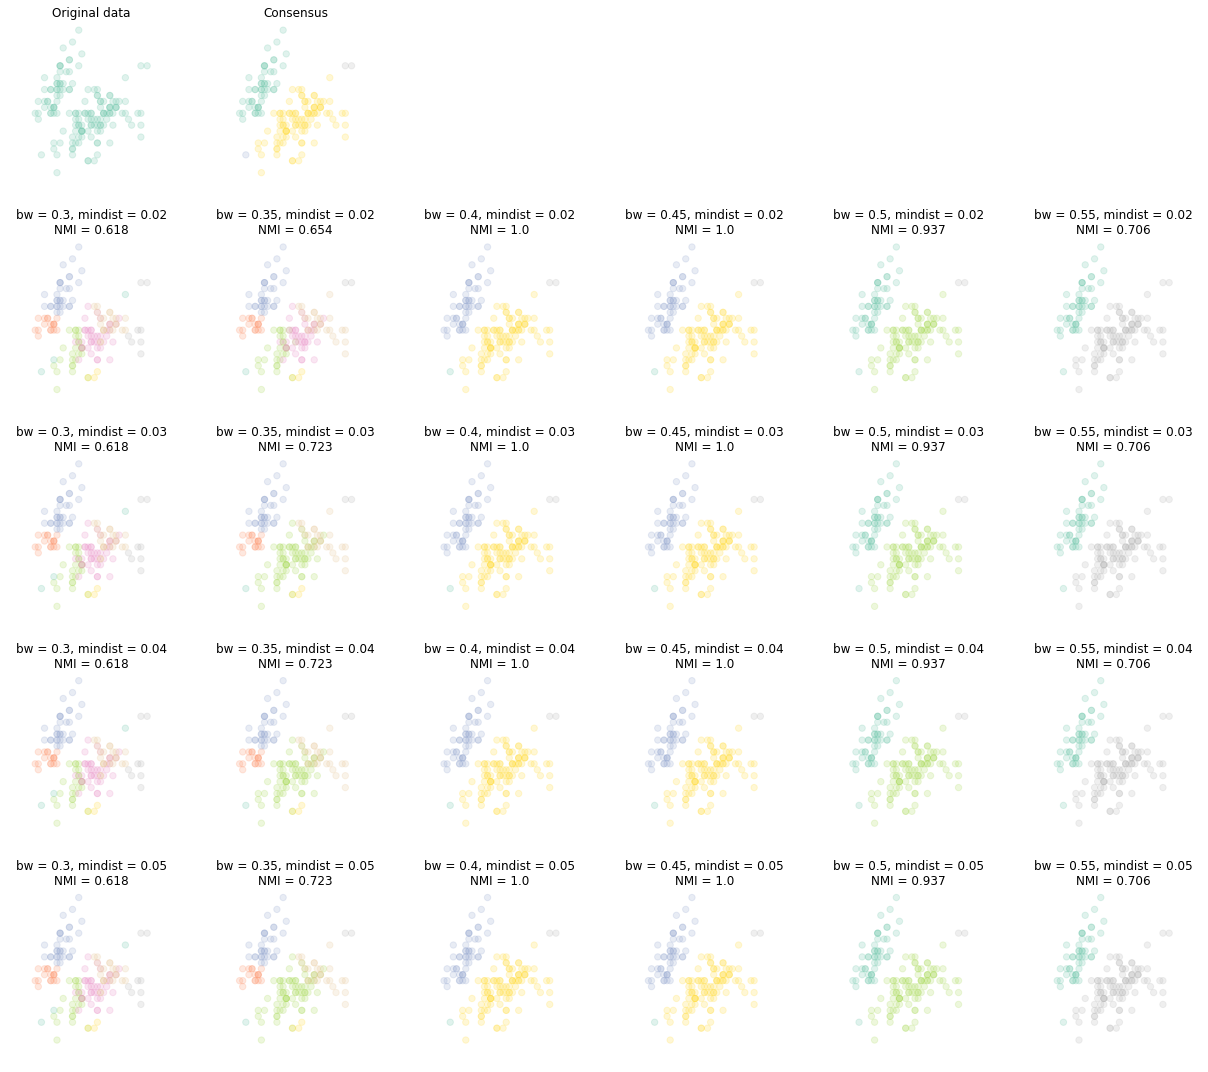

In [80]:
plot_results(data=data, cl_objects=cl_objects_ms, nmi_arr=nmi_arr_ms, consensus_obj=consensus_obj_ms, algorithm='meanshift', arr_x=bw_arr, arr_y=mindist_arr)

In [83]:
mutinf_cons = metrics.adjusted_mutual_info_score(labels , foundlabels)  
fm_index_cons = metrics.fowlkes_mallows_score(foundlabels, labels)

In [84]:
print("Mutual information between consensus clustering labels and natural/true labels:", mutinf_cons)
print("Fowlkes-Mallows index between consensus clustering labels and natural/true labels:", fm_index_cons)

Mutual information between consensus clustering labels and natural/true labels: 0.718598359141
Fowlkes-Mallows index between consensus clustering labels and natural/true labels: 0.769006995608


Consensus Result

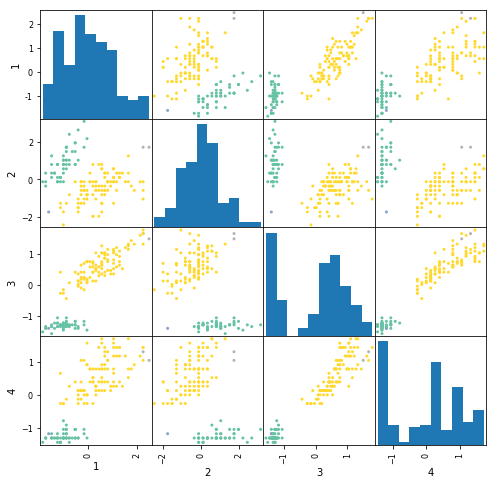

In [85]:
s=scatter_matrix(dataframekm[["1","2","3","4"]], alpha=1, figsize=(8,8), c = consensus_obj_ms.cluster_labels, cmap='Set2')

In [86]:
#best parameters for DBSCAN -> highest NMI with consensus clustering (might not be unique parameter choice)
print("The best parameter choice for DBSCAN (given the chosen range) has NMI ", np.max(nmi_arr_ms), " compared to the consensus result")

The best parameter choice for DBSCAN (given the chosen range) has NMI  1.0  compared to the consensus result
